# Importing Libraries

In [7]:
import cv2
import os
import numpy as np
from PIL import Image
from keras.utils import to_categorical
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense


# Data Exploring

In [3]:
# Define the paths to your dataset
closed_path = r"D:\mini project\yawn_eye_dataset\dataset_new\train\Closed"
no_yawn_path = r"D:\mini project\yawn_eye_dataset\dataset_new\train\no_yawn"
open_path = r"D:\mini project\yawn_eye_dataset\dataset_new\train\Open"
yawn_path = r"D:\mini project\yawn_eye_dataset\dataset_new\train\yawn"

# Function to count the number of files in a directory
def count_files(directory):
    return len(os.listdir(directory))

# Count the number of files in each class
closed_count = count_files(closed_path)
no_yawn_count = count_files(no_yawn_path)
open_count = count_files(open_path)
yawn_count = count_files(yawn_path)

# Print the counts
print("Number of files in 'Closed' class:", closed_count)
print("Number of files in 'No Yawn' class:", no_yawn_count)
print("Number of files in 'Open' class:", open_count)
print("Number of files in 'Yawn' class:", yawn_count)


Number of files in 'Closed' class: 617
Number of files in 'No Yawn' class: 616
Number of files in 'Open' class: 617
Number of files in 'Yawn' class: 617


Images from 'Closed' class:


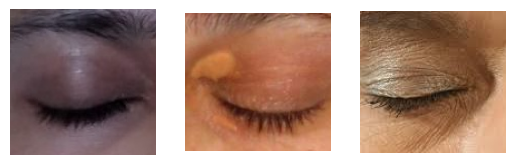

Images from 'No Yawn' class:


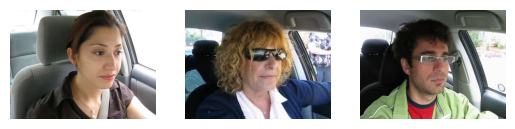

Images from 'Open' class:


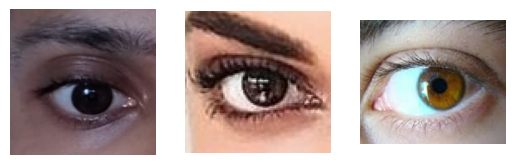

Images from 'Yawn' class:


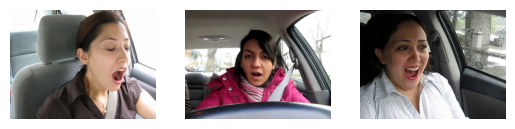

In [8]:
# Function to load and display images from a directory
def display_images(directory, num_images=5):
    image_files = os.listdir(directory)
    for i in range(num_images):
        image_path = os.path.join(directory, image_files[i])
        image = Image.open(image_path)
        plt.subplot(1, num_images, i+1)
        plt.imshow(image)
        plt.axis('off')
    plt.show()

# Display images from each class
num_images = 3  # Number of images to display per class

print("Images from 'Closed' class:")
display_images(closed_path, num_images)

print("Images from 'No Yawn' class:")
display_images(no_yawn_path, num_images)

print("Images from 'Open' class:")
display_images(open_path, num_images)

print("Images from 'Yawn' class:")
display_images(yawn_path, num_images)

# Loading Haarcascade Files

In [1]:

face_cas_path = r"D:\project finals\haarcascade_frontalface_default.xml"
eye_cas_path = r"D:\project finals\haarcascade_eye.xml"
mouth_cas_path = r"D:\project finals\haarcascade_mouth.xml"


# Data Preprocessing

In [6]:
import cv2
import os
import numpy as np

def face_for_yawn(direc=r"D:\mini project\yawn_eye_dataset\dataset_new\train", output_dir=r"D:\mini project\face_prep"):
    yaw_no = []
    IMG_SIZE = 145
    categories = ["yawn", "no_yawn"]
    
    face_cascade = cv2.CascadeClassifier(face_cas_path)
    eye_cascade = cv2.CascadeClassifier(eye_cas_path)
    mouth_cascade = cv2.CascadeClassifier(mouth_cas_path)
    
    for category in categories:
        path_link = os.path.join(direc, category)
        class_num1 = categories.index(category)
        print(class_num1)
        for image in os.listdir(path_link):
            image_path = os.path.join(path_link, image)
            image_array = cv2.imread(image_path, cv2.IMREAD_COLOR)
            gray_image = cv2.cvtColor(image_array, cv2.COLOR_BGR2GRAY)
            
            faces = face_cascade.detectMultiScale(gray_image, 1.3, 5)
            
            for (x, y, w, h) in faces:
                roi_gray = gray_image[y:y+h, x:x+w]
                roi_color = image_array[y:y+h, x:x+w]
                
                eyes = eye_cascade.detectMultiScale(roi_gray)
                mouth = mouth_cascade.detectMultiScale(roi_gray)
                
                # Check if eyes are closed
                if len(eyes) == 0:
                    eyes_closed = True
                else:
                    eyes_closed = False
                
                # Check if mouth is open (yawn)
                if len(mouth) > 0:
                    mouth_open = True
                else:
                    mouth_open = False
                
                img = cv2.rectangle(image_array, (x, y), (x+w, y+h), (0, 255, 0), 2)
                resized_array = cv2.resize(roi_color, (IMG_SIZE, IMG_SIZE))
                yaw_no.append([resized_array, class_num1, eyes_closed, mouth_open])
                
                # Save the preprocessed image
                image_filename = f"preprocessed_image_{category}_{len(yaw_no)}.jpg"
                output_path = os.path.join(output_dir, image_filename)
                cv2.imwrite(output_path, resized_array)

    return yaw_no


In [7]:

yaw_no = face_for_yawn()

0
1


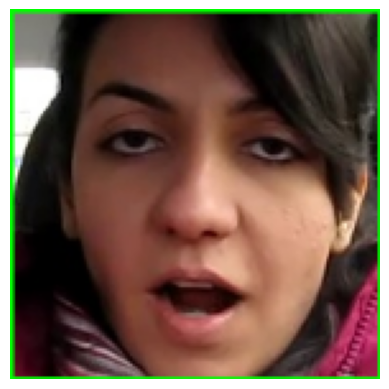

In [10]:

import matplotlib.pyplot as plt
preprocessed_image = yaw_no[0][0]  # Accessing the first preprocessed image

# Display the preprocessed image
plt.imshow(cv2.cvtColor(preprocessed_image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

In [11]:
from keras.preprocessing.image import ImageDataGenerator

def get_data(dir_path=r"D:\mini project\yawn_eye_dataset\dataset_new\train",
             face_cas=r"D:\mini project\haarcascade_frontalface_default.xml",
             eye_cas=r"D:\mini project\haarcascade_eye.xml",
             save_dir=r"D:\mini project\haarcascade_eye.xml"):
    labels = ['Closed', 'Open']
    IMG_SIZE = 145
    data = []
    
    augmentation = ImageDataGenerator(
            rotation_range=10,
            width_shift_range=0.1,
            height_shift_range=0.1,
            zoom_range=0.1,
            horizontal_flip=True
        )

    for label in labels:
            path = os.path.join(dir_path, label)
            class_num = labels.index(label) + 2
            print("Class number:", class_num)

            for img in os.listdir(path):
                try:
                    img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_COLOR)
                    resized_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
                    augmented_images = augmentation.flow(np.expand_dims(resized_array, axis=0), batch_size=1)

                    for i in range(5):  # Generate 5 augmented images for each original image
                        augmented_image = next(augmented_images)[0].astype(np.uint8)
                        data.append([augmented_image, class_num])
                        print("Augmented image shape:", augmented_image.shape)

                        # Save the augmented image
                        save_path = os.path.join(save_dir, f"augmented_image_{len(data)}.jpg")
                        cv2.imwrite(save_path, augmented_image)
                except Exception as e:
                    print(e)

    return data



In [12]:
# Generate augmented images for the "Closed" and "Open" eye classes
eye_data = get_data()

Class number: 2
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape:

Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
A

Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
A

Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
A

Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
A

Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
A

Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
A

Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
A

Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
A

Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
A

Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
A

Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
A

Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
A

Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
A

Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
A

Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
A

Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
A

Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
A

Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
A

Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
A

Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
A

Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
A

Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
A

Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
A

Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
A

Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
A

In [13]:
# Extract face, eye, and mouth regions from the images of people yawning and not yawning
yawn_data = face_for_yawn()

0
1


In [14]:
# Combine the datasets
data = eye_data + yawn_data

In [15]:
# Display the total number of images
print("Total number of images:", len(data))

Total number of images: 6580


In [16]:
def append_data():
#     total_data = []
    yaw_no = face_for_yawn()
    data = get_data()
    yaw_no.extend(data)
    return np.array(yaw_no)

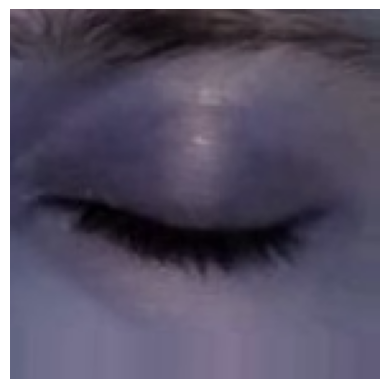

In [17]:

import matplotlib.pyplot as plt

# Assuming you have already called the `get_data` function and stored the result in `data`
if len(data) > 0:  # Check if the `data` list is not empty
    image_array = data[0][0]  # Accessing the first image array from the data list
    # Display the image
    plt.imshow(image_array)
    plt.axis('off')
    plt.show()
else:
    print("The data list is empty. Make sure to load or generate the data before accessing it.")

In [18]:

from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.layers import Dropout

In [20]:
preprocessed_data = append_data()

0
1
Class number: 2
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image sh

Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
A

Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
A

Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
A

Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
A

Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
A

Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
A

Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
A

Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
A

Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
A

Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
A

Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
A

Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
A

Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
A

Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
A

Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
A

Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
A

Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
A

Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
A

Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
A

Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
A

Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
A

Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
A

Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
A

Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
A

Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)
Augmented image shape: (145, 145, 3)


C:\Users\aruni\AppData\Local\Temp\ipykernel_11760\2804427426.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(yaw_no)


In [21]:
# Step 2: Split the data into training and testing sets
X = np.array([item[0] for item in preprocessed_data])
y = np.array([item[1] for item in preprocessed_data])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



In [23]:
import numpy as np
from keras.utils import to_categorical

# Create new target labels for DROWSY and NON DROWSY
y_train_new = np.zeros_like(y_train)
y_test_new = np.zeros_like(y_test)

# Identify DROWSY samples
drowsy_indices_train = np.logical_or(y_train == 0, y_train == 2)
y_train_new = np.where(drowsy_indices_train, 1, y_train_new)

drowsy_indices_test = np.logical_or(y_test == 0, y_test == 2)
y_test_new = np.where(drowsy_indices_test, 1, y_test_new)

# Convert target labels to binary format
y_train_new = to_categorical(y_train_new, num_classes=2)
y_test_new = to_categorical(y_test_new, num_classes=2)


In [24]:

import numpy as np
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

# Define the model architecture
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(145, 145, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(2, activation='softmax'))  # Output layer with 2 classes


In [34]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 143, 143, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 71, 71, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 69, 69, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 34, 34, 64)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 73984)             0         
                                                                 
 dense (Dense)               (None, 128)               9

In [25]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

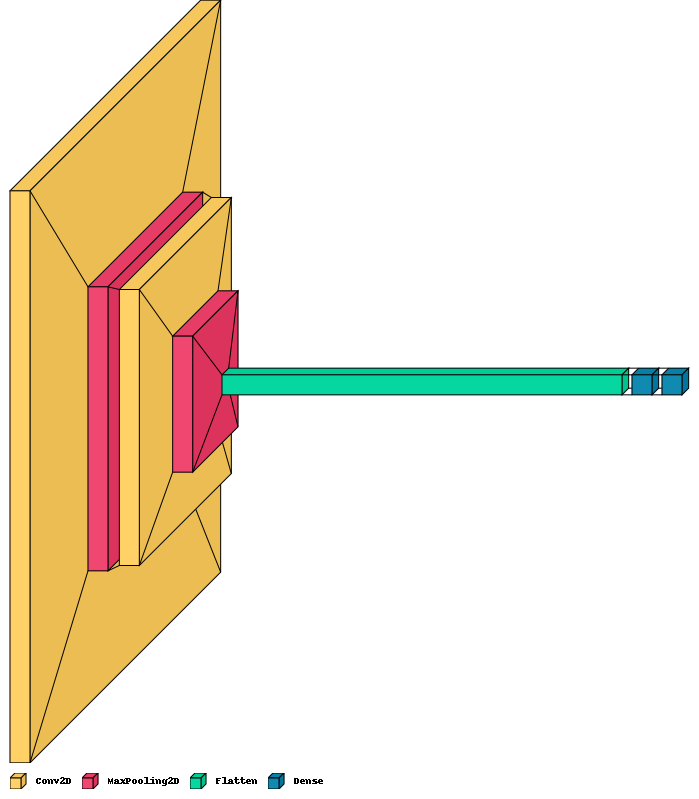

In [26]:
import visualkeras
from PIL import ImageFont
visualkeras.layered_view(model, legend=True)

In [27]:

history=model.fit(X_train, y_train_new, epochs=10, batch_size=32, validation_data=(X_test, y_test_new))

Epoch 1/10
165/165 [==============================] - 69s 412ms/step - loss: 32.0236 - accuracy: 0.8545 - val_loss: 0.2656 - val_accuracy: 0.9103
Epoch 2/10
165/165 [==============================] - 70s 422ms/step - loss: 0.1957 - accuracy: 0.9362 - val_loss: 0.6093 - val_accuracy: 0.8435
Epoch 3/10
165/165 [==============================] - 72s 436ms/step - loss: 0.1538 - accuracy: 0.9445 - val_loss: 0.2553 - val_accuracy: 0.9096
Epoch 4/10
165/165 [==============================] - 68s 412ms/step - loss: 0.0964 - accuracy: 0.9649 - val_loss: 0.2153 - val_accuracy: 0.9362
Epoch 5/10
165/165 [==============================] - 64s 387ms/step - loss: 1.4812 - accuracy: 0.8801 - val_loss: 0.2386 - val_accuracy: 0.9255
Epoch 6/10
165/165 [==============================] - 64s 387ms/step - loss: 0.1152 - accuracy: 0.9588 - val_loss: 0.2132 - val_accuracy: 0.9278
Epoch 7/10
165/165 [==============================] - 64s 388ms/step - loss: 0.0787 - accuracy: 0.9685 - val_loss: 0.2068 - val_a

In [29]:
model.save('drowsy_com_model.h5')

42/42 [==============================] - 3s 63ms/step
Accuracy: 0.939209726443769
Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.97      0.94       653
           1       0.97      0.91      0.94       663

    accuracy                           0.94      1316
   macro avg       0.94      0.94      0.94      1316
weighted avg       0.94      0.94      0.94      1316



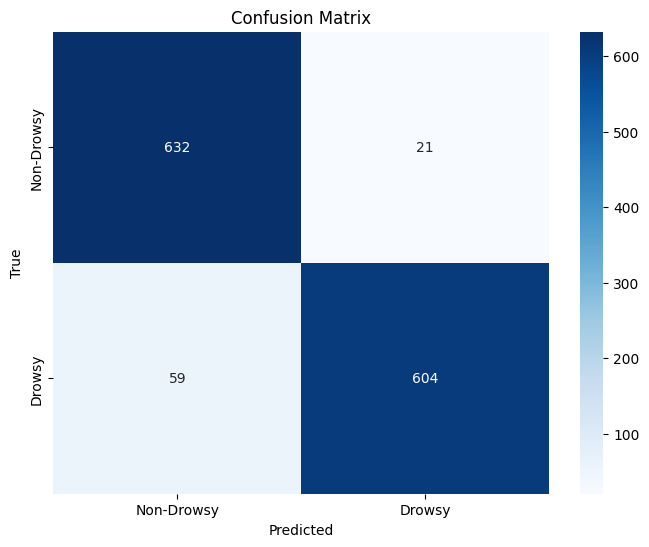

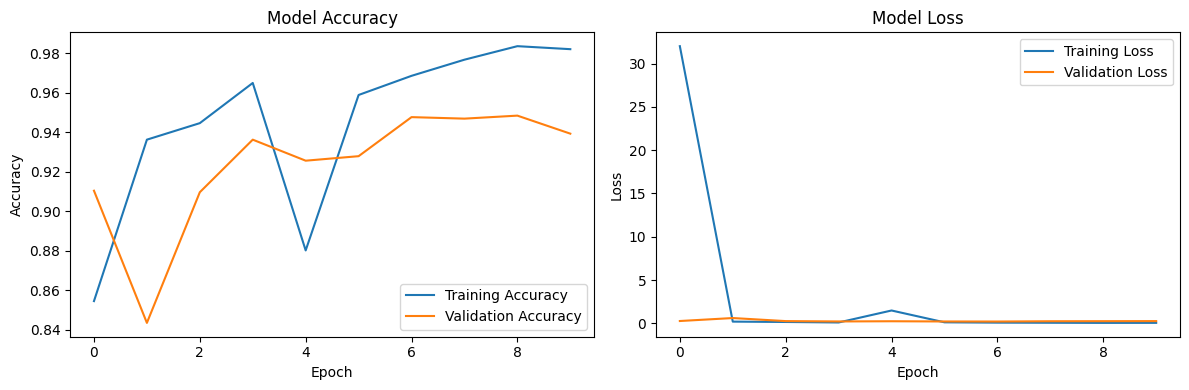

In [28]:
import numpy as np
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# X_test, y_test_new

# Make predictions on the test set
y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)  # Convert probabilities to class labels



# Calculate accuracy
accuracy = accuracy_score(np.argmax(y_test_new, axis=1), y_pred_labels)
print("Accuracy:", accuracy)



# Calculate precision, recall, and F1 score
report = classification_report(np.argmax(y_test_new, axis=1), y_pred_labels)
print("Classification Report:\n", report)


import seaborn as sns
import matplotlib.pyplot as plt

# Calculate confusion matrix
cm = confusion_matrix(np.argmax(y_test_new, axis=1), y_pred_labels)

# Define class labels
class_labels = ['Non-Drowsy', 'Drowsy']

# Plot confusion matrix with color coding
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


# Plot accuracy and validation curves
plt.figure(figsize=(12, 4))

# Accuracy curve
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss curve
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
import cv2
import pygame
import time
from keras.models import load_model
import numpy as np

# Load the trained model
model = load_model(r"D:\project finals\drowsy_com_model.h5")

# Load the haarcascade for face detection
face_cascade = cv2.CascadeClassifier(face_cas_path)

# Define the labels
labels = ['Non-Drowsy', 'Drowsy']

# Define a variable to keep track of the last detected drowsy timestamp
last_drowsy_time = 0
# Define the threshold time in seconds
drowsy_threshold = 3 
# Initialize the pygame mixer
pygame.mixer.init()

# Load the alert sound
alert_sound = pygame.mixer.Sound(r"C:\Users\aruni\OneDrive\Desktop\alert-sound.mp3")

# ...

# Define a function to process frames from the camera
def process_frame(frame):
    global last_drowsy_time  # Declare last_drowsy_time as a global variable
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)

    for (x, y, w, h) in faces:
        face_img = frame[y:y+h, x:x+w]
        resized_img = cv2.resize(face_img, (145, 145))
        normalized_img = resized_img / 255.0  # Normalize the image
        reshaped_img = np.reshape(normalized_img, (1, 145, 145, 3))
        
        # Predict the class probabilities
        predictions = model.predict(reshaped_img)
        predicted_class = np.argmax(predictions[0])
        label = labels[predicted_class]
        
        # Display the label on the frame
        cv2.putText(frame, label, (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)
        cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 0), 2)
        
        # Inside the loop where you process frames
        if predicted_class == 1:
            # Check if enough time has elapsed since the last drowsy detection
            if time.time() - last_drowsy_time >= drowsy_threshold:
                # Play the alert sound if it's not already playing
                if not pygame.mixer.get_busy():
                    alert_sound.play()
                    last_drowsy_time = time.time()
        else:
            # Stop the alert sound if it's playing
            if pygame.mixer.get_busy():
                alert_sound.stop()

    return frame

# ...

# Open the camera
cap = cv2.VideoCapture(0)

while True:
    ret, frame = cap.read()

    if ret:
        processed_frame = process_frame(frame)

        # Display the frame
        cv2.imshow('Drowsiness Detection', processed_frame)

        # Break the loop if 'q' is pressed
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

# Release the capture and close windows
cap.release()
cv2.destroyAllWindows()


pygame 2.4.0 (SDL 2.26.4, Python 3.10.11)
Hello from the pygame community. https://www.pygame.org/contribute.html
1/1 [==============================] - 0s 36ms/step


1/1 [==============================] - 0s 23ms/step
